# Project is Bert4rec system. Providing Time Based Recommendations

In [1]:
!unzip ml-25m.zip

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [3]:
!pip install pandasai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 161.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 36.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4


In [2]:
import numpy as np
import pandas as pd

In [4]:
ratings_df = pd.read_csv("ml-25m/ratings.csv")

In [5]:
ratings_df.head()

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

In [17]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')


In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 762.9 MB


In [6]:
movies_df = pd.read_csv("ml-25m/movies.csv")

In [7]:
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [8]:
# Adding movie title to ratings_df
data = pd.merge(ratings_df, movies_df[["movieId" , "title"]] , on = "movieId", how = "left") 

In [9]:
data.head()

userId  movieId  rating   timestamp  \
0       1      296     5.0  1147880044   
1       1      306     3.5  1147868817   
2       1      307     5.0  1147868828   
3       1      665     5.0  1147878820   
4       1      899     3.5  1147868510   

                                              title  
0                               Pulp Fiction (1994)  
1  Three Colors: Red (Trois couleurs: Rouge) (1994)  
2  Three Colors: Blue (Trois couleurs: Bleu) (1993)  
3                                Underground (1995)  
4                        Singin' in the Rain (1952)

# Organize Data by User:
Group by User: For each userId, collect all the movie interactions (movies watched) and organize them chronologically based on the timestamp

# user_movie_interactions contains user-movie arrannged based on time movie watched

In [10]:
user_movie_interactions = data.groupby("userId").apply(lambda x: x.sort_values("timestamp"))

In [11]:
import datetime
user_movie_interactions["timestamp_formatted"] = user_movie_interactions["timestamp"].apply(
    lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')
)

In [12]:
user_movie_interactions = user_movie_interactions.reset_index(drop=True)


In [13]:
user_movie_interactions.head()

userId  movieId  rating   timestamp  \
0       1     5952     4.0  1147868053   
1       1     2012     2.5  1147868068   
2       1     2011     2.5  1147868079   
3       1     1653     4.0  1147868097   
4       1     1250     4.0  1147868414   

                                           title timestamp_formatted  
0  Lord of the Rings: The Two Towers, The (2002)          2006-05-17  
1             Back to the Future Part III (1990)          2006-05-17  
2              Back to the Future Part II (1989)          2006-05-17  
3                                 Gattaca (1997)          2006-05-17  
4           Bridge on the River Kwai, The (1957)          2006-05-17

In [14]:
# Reset the index if 'userId' is in the index

# Now, you can group by 'userId' without ambiguity
user_movie_sequences = user_movie_interactions.groupby('userId').apply(
    lambda x: [{'timestamp': row['timestamp_formatted'], 'movie': row['title']} for _, row in x.iterrows()]
)


In [16]:
user_movie_sequences.to_csv("user_movie_sequences.csv")

In [2]:
user_movie_sequences = pd.read_csv("user_movie_sequences.csv")

In [3]:
user_movie_sequences.columns = ['userId', 'movie-list']

In [53]:
user_movie_sequences.head()

userId                                         movie-list
0       1  [{'timestamp': '2006-05-17', 'movie': 'Lord of...
1       2  [{'timestamp': '2006-03-03', 'movie': 'Big (19...
2       3  [{'timestamp': '2015-08-13', 'movie': 'Forrest...
3       4  [{'timestamp': '2019-11-16', 'movie': 'Wreck-I...
4       5  [{'timestamp': '1996-04-29', 'movie': 'Batman ...

In [54]:
user_movie_sequences.to_json('user_movie_sequences.json', orient='records')


# checking duplicates
duplicates are movies repeating in list of movies for a user.
    \
    find out time gap between the duplicates. ie rewatched movies

In [5]:
# def check_for_duplicates(movie_list):
#     movie_seen = {}
#     for entry in movie_list:
#         # Assuming entry is a dictionary, if not adjust as needed
#         movie = entry.get('movie')  # Use .get() in case the key doesn't exist
#         timestamp = entry.get('timestamp')

#         # Parse timestamp if it's not None
#         if timestamp:
#             timestamp = datetime.strptime(timestamp, '%Y-%m-%d')  # Assuming the format is YYYY-MM-DD

#         # Check for duplicates and calculate time difference
#         if movie and movie in movie_seen:
#             time_diff = timestamp - movie_seen[movie]
#             print(f"Duplicate movie: {movie}, Time since last watch: {time_diff}")
#         movie_seen[movie] = timestamp
from datetime import datetime

# Function to check for duplicates and store the info
def check_for_duplicates(movie_list):
    movie_seen = {}
    duplicates_info = []  # List to store information about duplicates

    for entry in movie_list:
        movie = entry.get('movie')  # Use .get() to avoid errors if key doesn't exist
        timestamp = entry.get('timestamp')

        # Parse timestamp if it's not None
        if timestamp:
            timestamp = datetime.strptime(timestamp, '%Y-%m-%d')  # Assuming the format is YYYY-MM-DD

        # Check for duplicates and calculate time difference
        if movie and movie in movie_seen:
            time_diff = timestamp - movie_seen[movie]
            # Save the duplicate info as a dictionary
            duplicates_info.append({
                'movie': movie,
                'last_watch_date': movie_seen[movie],
                'current_watch_date': timestamp,
                'time_difference': time_diff
            })
        
        # Update the last watched time for the movie
        movie_seen[movie] = timestamp

    return duplicates_info


In [13]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


In [34]:

import ast

# Extract the movie list for userId == 1 and convert from string to list of dictionaries
user_movie_list_str = user_movie_sequences.loc[user_movie_sequences['userId'] == 1, 'movie-list'].values[0]

# Convert string representation to a list of dictionaries
user_movie_list = ast.literal_eval(user_movie_list_str)

In [35]:
print(type(user_movie_list[0]))


<class 'dict'>


In [36]:
print(user_movie_list[0])

{'timestamp': '2006-05-17', 'movie': 'Lord of the Rings: The Two Towers, The (2002)'}


In [37]:
#trying for user 1
check_for_duplicates(user_movie_list)

In [12]:
user_movie_list

NameError: name 'user_movie_list' is not defined

In [15]:
import ast
def process_all_users(user_movie_sequences):
    all_duplicates_info = {}  # Dictionary to store duplicates info for each user
    
    for index, row in user_movie_sequences.iterrows():
        # Convert string representation to a list of dictionaries
        user_movie_list_str = row['movie-list']
        user_movie_list = ast.literal_eval(user_movie_list_str)
        
        # Now pass this to the check_for_duplicates function
        print(f"Processing userId: {row['userId']}")
        duplicates_info = check_for_duplicates(user_movie_list)
        
        # Save the duplicate info for each userId
        all_duplicates_info[row['userId']] = duplicates_info
    
    return all_duplicates_info
# Apply the function to all users
duplicates_info = process_all_users(user_movie_sequences)

Processing userId: 1
Processing userId: 2
Processing userId: 3
Processing userId: 4
Processing userId: 5
Processing userId: 6
Processing userId: 7
Processing userId: 8
Processing userId: 9
Processing userId: 10
Processing userId: 11
Processing userId: 12
Processing userId: 13
Processing userId: 14
Processing userId: 15
Processing userId: 16
Processing userId: 17
Processing userId: 18
Processing userId: 19
Processing userId: 20
Processing userId: 21
Processing userId: 22
Processing userId: 23
Processing userId: 24
Processing userId: 25
Processing userId: 26
Processing userId: 27
Processing userId: 28
Processing userId: 29
Processing userId: 30
Processing userId: 31
Processing userId: 32
Processing userId: 33
Processing userId: 34
Processing userId: 35
Processing userId: 36
Processing userId: 37
Processing userId: 38
Processing userId: 39
Processing userId: 40
Processing userId: 41
Processing userId: 42
Processing userId: 43
Processing userId: 44
Processing userId: 45
Processing userId: 

Processing userId: 120
Processing userId: 121
Processing userId: 122
Processing userId: 123
Processing userId: 124
Processing userId: 125
Processing userId: 126
Processing userId: 127
Processing userId: 128
Processing userId: 129
Processing userId: 130
Processing userId: 131
Processing userId: 132
Processing userId: 133
Processing userId: 134
Processing userId: 135
Processing userId: 136
Processing userId: 137
Processing userId: 138
Processing userId: 139
Processing userId: 140
Processing userId: 141
Processing userId: 142
Processing userId: 143
Processing userId: 144
Processing userId: 145
Processing userId: 146
Processing userId: 147
Processing userId: 148
Processing userId: 149
Processing userId: 150
Processing userId: 151
Processing userId: 152
Processing userId: 153
Processing userId: 154
Processing userId: 155
Processing userId: 156
Processing userId: 157
Processing userId: 158
Processing userId: 159
Processing userId: 160
Processing userId: 161
Processing userId: 162
Processing 

In [19]:
duplicates_info[len(duplicates_info) > 0]

[]

In [29]:
filtered_duplicates = {user_id: duplicates for user_id, duplicates in duplicates_info.items() if len(duplicates) > 0}
flattened_data = []

# Iterate over the filtered duplicates
for user_id, duplicates in filtered_duplicates.items():
    for duplicate in duplicates:
        flattened_data.append({
            'user_id': user_id,
            'movie': duplicate['movie'],
            'last_watch_date': duplicate['last_watch_date'],
            'current_watch_date': duplicate['current_watch_date'],
            'time_difference': duplicate['time_difference']
        })

# Now create a DataFrame from the flattened data
filtered_duplicates_df = pd.DataFrame(flattened_data)

# Check the DataFrame
print(filtered_duplicates_df)# Check the filtered results




     user_id                                        movie last_watch_date  \
0        494                     War of the Worlds (2005)      2012-06-28   
1       1428       Confessions of a Dangerous Mind (2002)      2018-11-17   
2       1652       Confessions of a Dangerous Mind (2002)      2017-08-22   
3       1748  Enron: The Smartest Guys in the Room (2005)      2012-06-03   
4       1833                     War of the Worlds (2005)      2009-01-04   
..       ...                                          ...             ...   
604   161675       Confessions of a Dangerous Mind (2002)      2017-05-07   
605   161692                     War of the Worlds (2005)      2009-01-01   
606   161826                     War of the Worlds (2005)      2006-08-24   
607   162083                     War of the Worlds (2005)      2015-11-03   
608   162271                                  Eros (2004)      2010-02-28   

    current_watch_date time_difference  
0           2012-06-28          0 

In [40]:
# Filter the DataFrame for time difference less than 30 days and users with more than 1 duplicate entry
filtered_df = filtered_duplicates_df[(filtered_duplicates_df["time_difference"] < pd.Timedelta(days=30)) & 
                                     (filtered_duplicates_df.groupby("user_id")["user_id"].transform('size') > 1)]




     user_id                                        movie last_watch_date  \
9       2938       Confessions of a Dangerous Mind (2002)      2016-10-29   
74     19507       Confessions of a Dangerous Mind (2002)      2019-03-02   
75     19507                              The Void (2016)      2019-03-03   
108    29803                                 Noise (2007)      2018-12-18   
111    31047       Confessions of a Dangerous Mind (2002)      2016-05-06   
112    31047                         Clear History (2013)      2017-03-22   
152    40636                           The Promise (2016)      2019-03-29   
153    40636       Confessions of a Dangerous Mind (2002)      2019-03-29   
174    47001                     War of the Worlds (2005)      2015-08-14   
231    61624                     War of the Worlds (2005)      2010-10-11   
267    72315                                  Sing (2016)      2017-03-22   
294    75309                                Frozen (2010)      2019-05-24   

In [31]:
filtered_duplicates_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   user_id             609 non-null    int64          
 1   movie               609 non-null    object         
 2   last_watch_date     609 non-null    datetime64[ns] 
 3   current_watch_date  609 non-null    datetime64[ns] 
 4   time_difference     609 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 23.9+ KB


In [52]:
# Check the filtered results
filtered_df[filtered_df['user_id'].isin(filtered_df['user_id'].unique())]


user_id                                        movie last_watch_date  \
9       2938       Confessions of a Dangerous Mind (2002)      2016-10-29   
74     19507       Confessions of a Dangerous Mind (2002)      2019-03-02   
75     19507                              The Void (2016)      2019-03-03   
108    29803                                 Noise (2007)      2018-12-18   
111    31047       Confessions of a Dangerous Mind (2002)      2016-05-06   
112    31047                         Clear History (2013)      2017-03-22   
152    40636                           The Promise (2016)      2019-03-29   
153    40636       Confessions of a Dangerous Mind (2002)      2019-03-29   
174    47001                     War of the Worlds (2005)      2015-08-14   
231    61624                     War of the Worlds (2005)      2010-10-11   
267    72315                                  Sing (2016)      2017-03-22   
294    75309                                Frozen (2010)      2019-05-24   
295    75309                           Blood Money (2017)      2019-05-24   
296    75309                              Cold War (2018)      2019-05-24   
339    85757                                  Sing (2016)      2017-06-26   
406   103611                                  Sing (2016)      2017-08-30   
407   103611                         Clockstoppers (2002)      2017-09-01   
476   126637                                 Noise (2007)      2019-03-24   
482   129892                     War of the Worlds (2005)      2018-09-24   
483   129892                              Saturn 3 (1980)      2018-09-24   
484   129892                         Clockstoppers (2002)      2018-09-25   
488   131412       Confessions of a Dangerous Mind (2002)      2019-10-07   
489   131412  Enron: The Smartest Guys in the Room (2005)      2019-10-07   
501   134045                                Gossip (2000)      2017-01-14   
502   134045       Confessions of a Dangerous Mind (2002)      2017-01-14   
514   137293                     War of the Worlds (2005)      2009-05-09   

    current_watch_date time_difference  
9           2016-10-29          0 days  
74          2019-03-03          1 days  
75          2019-03-03          0 days  
108         2018-12-18          0 days  
111         2016-05-06          0 days  
112         2017-03-22          0 days  
152         2019-03-29          0 days  
153         2019-03-29          0 days  
174         2015-08-18          4 days  
231         2010-10-17          6 days  
267         2017-03-22          0 days  
294         2019-05-24          0 days  
295         2019-05-24          0 days  
296         2019-05-24          0 days  
339         2017-07-24         28 days  
406         2017-09-06          7 days  
407         2017-09-06          5 days  
476         2019-03-24          0 days  
482         2018-09-25          1 days  
483         2018-09-25          1 days  
484         2018-09-25          0 days  
488         2019-10-07          0 days  
489         2019-10-07          0 days  
501         2017-01-14          0 days  
502         2017-01-22          8 days  
514         2009-05-09          0 days

# No conclusion about duplicates found. 
        outof all 162541 users_id , only 16 have watched a movie again and the time difference is either too long like 180 days or 300 days etc .. or too less 1 ,2 days. This does not give any hidden info about the user behaviour.


# step 2 - Plot distributon of len of list of movies watched by user

In [3]:
user_movie_sequences = pd.read_json("/teamspace/studios/this_studio/user_movie_sequences.json")
user_movie_sequences.head(10)

userId                                         movie-list
0       1  [{'timestamp': '2006-05-17', 'movie': 'Lord of...
1       2  [{'timestamp': '2006-03-03', 'movie': 'Big (19...
2       3  [{'timestamp': '2015-08-13', 'movie': 'Forrest...
3       4  [{'timestamp': '2019-11-16', 'movie': 'Wreck-I...
4       5  [{'timestamp': '1996-04-29', 'movie': 'Batman ...
5       6  [{'timestamp': '1999-12-14', 'movie': 'Crimson...
6       7  [{'timestamp': '1996-06-22', 'movie': 'Apollo ...
7       8  [{'timestamp': '1998-03-21', 'movie': 'Rainmak...
8       9  [{'timestamp': '1997-03-26', 'movie': 'Willy W...
9      10  [{'timestamp': '2008-11-24', 'movie': 'Driving...

In [6]:
import ast
user_movie_sequences["len-of-list"] = user_movie_sequences["movie-list"].apply(lambda x: len(ast.literal_eval(x)))


In [7]:
user_movie_sequences

userId                                         movie-list  len-of-list
0            1  [{'timestamp': '2006-05-17', 'movie': 'Lord of...           70
1            2  [{'timestamp': '2006-03-03', 'movie': 'Big (19...          184
2            3  [{'timestamp': '2015-08-13', 'movie': 'Forrest...          656
3            4  [{'timestamp': '2019-11-16', 'movie': 'Wreck-I...          242
4            5  [{'timestamp': '1996-04-29', 'movie': 'Batman ...          101
...        ...                                                ...          ...
162536  162537  [{'timestamp': '2003-03-09', 'movie': 'Princes...          101
162537  162538  [{'timestamp': '2015-08-05', 'movie': 'Forrest...          154
162538  162539  [{'timestamp': '2001-07-14', 'movie': 'Titanic...           47
162539  162540  [{'timestamp': '2009-07-29', 'movie': 'Bone Co...           88
162540  162541  [{'timestamp': '2009-04-28', 'movie': 'Jackie ...          182

[162541 rows x 3 columns]

In [ ]:
plt.hist(user_movie_sequences["len-of-list"], bins=10, color='skyblue', edgecolor='black')

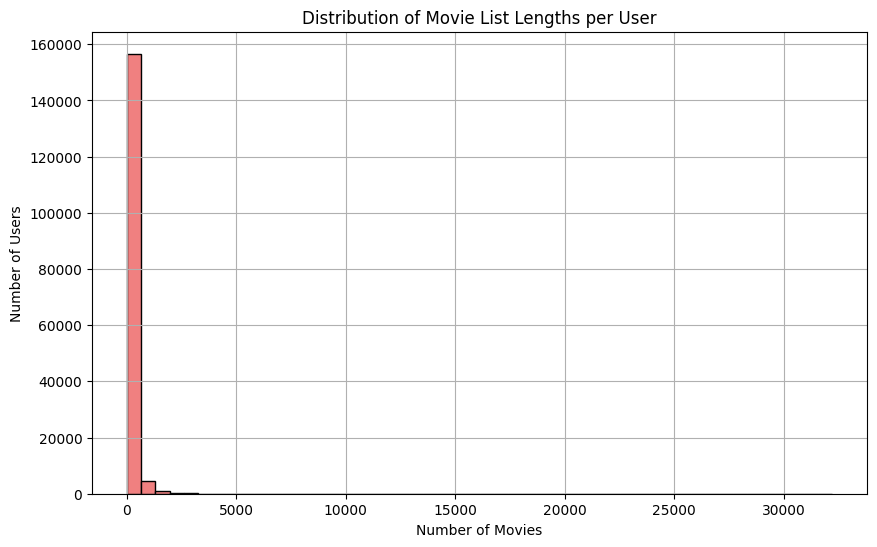

In [10]:
import matplotlib.pyplot as plt

# Plot histogram of movie list lengths
plt.figure(figsize=(10,6))
plt.hist(user_movie_sequences["len-of-list"], bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Movie List Lengths per User')
plt.xlabel('Number of Movies')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


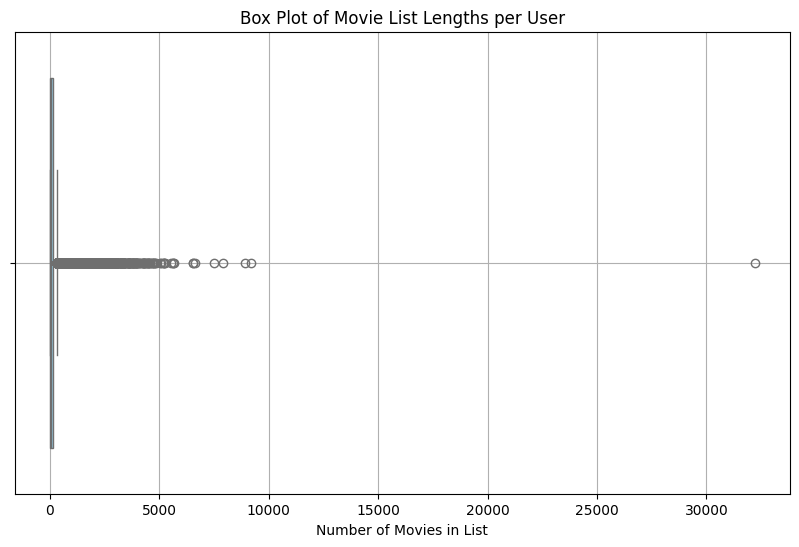

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot to visualize the distribution of movie list lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_movie_sequences["len-of-list"], color='skyblue')
plt.title('Box Plot of Movie List Lengths per User')
plt.xlabel('Number of Movies in List')
plt.grid(True)
plt.show()


# Plotting top 50 users i.e users who watched most movies


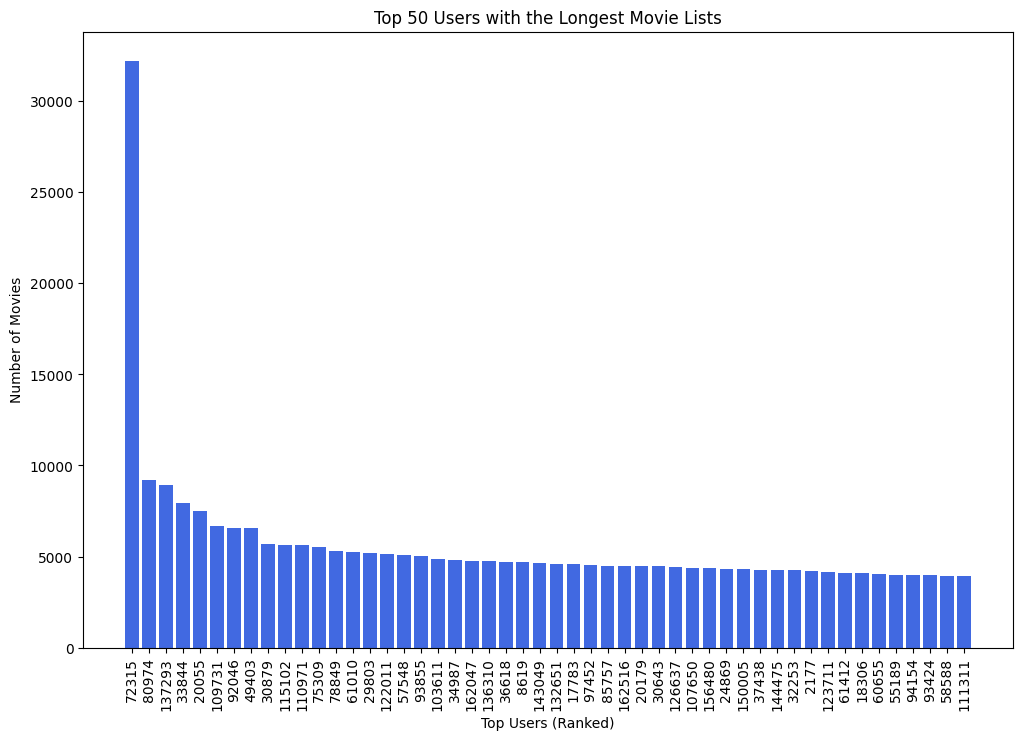

In [18]:
# Sort by the length of the movie lists and take the top 50 users
top_users = user_movie_sequences.nlargest(50, 'len-of-list')

# Bar plot for the top users
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_users)), top_users['len-of-list'], color='royalblue')  # Use a simple range for the x-axis
plt.title('Top 50 Users with the Longest Movie Lists')
plt.xlabel('Top Users (Ranked)')
plt.ylabel('Number of Movies')

# Use userId as labels but only for xticks (rotated for better readability)
plt.xticks(range(len(top_users)), top_users['userId'], rotation=90)

plt.show()

User 72315 watched 32202 movies. 

In [19]:
top_users

userId                                         movie-list  len-of-list
72314    72315  [{'timestamp': '2015-12-15', 'movie': 'Wild Ta...        32202
80973    80974  [{'timestamp': '2001-08-05', 'movie': 'Rocky I...         9178
137292  137293  [{'timestamp': '2009-04-07', 'movie': 'Arachno...         8913
33843    33844  [{'timestamp': '2012-12-13', 'movie': 'Risky B...         7919
20054    20055  [{'timestamp': '2006-10-10', 'movie': 'Chinato...         7488
109730  109731  [{'timestamp': '2002-07-05', 'movie': 'Torch S...         6647
92045    92046  [{'timestamp': '2001-09-10', 'movie': 'Without...         6564
49402    49403  [{'timestamp': '2000-04-07', 'movie': 'Star Wa...         6553
30878    30879  [{'timestamp': '2016-05-09', 'movie': 'Skyscra...         5693
115101  115102  [{'timestamp': '2016-06-25', 'movie': 'Shawsha...         5649
110970  110971  [{'timestamp': '2000-08-03', 'movie': 'Star Wa...         5633
75308    75309  [{'timestamp': '2019-05-24', 'movie': 'Nancy D...         5525
78848    78849  [{'timestamp': '2012-09-27', 'movie': 'Whateve...         5276
61009    61010  [{'timestamp': '2006-11-13', 'movie': 'Cast Aw...         5244
29802    29803  [{'timestamp': '2000-11-20', 'movie': 'Best Ma...         5219
122010  122011  [{'timestamp': '2002-08-19', 'movie': "Schindl...         5160
57547    57548  [{'timestamp': '2016-01-07', 'movie': 'Shawsha...         5066
93854    93855  [{'timestamp': '2006-01-09', 'movie': 'Chinato...         5045
103610  103611  [{'timestamp': '2017-08-29', 'movie': 'Shawsha...         4861
34986    34987  [{'timestamp': '1998-02-13', 'movie': 'L.A. Co...         4831
162046  162047  [{'timestamp': '2016-03-27', 'movie': 'Love (2...         4780
136309  136310  [{'timestamp': '2008-09-07', 'movie': 'Cell, T...         4764
36617    36618  [{'timestamp': '2017-01-26', 'movie': 'Shawsha...         4710
8618      8619  [{'timestamp': '2005-03-22', 'movie': 'Annie H...         4689
143048  143049  [{'timestamp': '1999-06-17', 'movie': 'Star Wa...         4663
132650  132651  [{'timestamp': '2010-11-28', 'movie': 'Tootsie...         4578
17782    17783  [{'timestamp': '2010-11-01', 'movie': 'Jerk, T...         4569
97451    97452  [{'timestamp': '2008-07-15', 'movie': 'Blue Ve...         4553
85756    85757  [{'timestamp': '2016-12-20', 'movie': 'Sky Cra...         4505
162515  162516  [{'timestamp': '1999-12-23', 'movie': 'Damien:...         4489
20178    20179  [{'timestamp': '2016-07-19', 'movie': 'Fight C...         4485
30642    30643  [{'timestamp': '2000-07-08', 'movie': 'North b...         4454
126636  126637  [{'timestamp': '2000-11-20', 'movie': 'Boiling...         4420
107649  107650  [{'timestamp': '2015-09-13', 'movie': 'Back to...         4352
156479  156480  [{'timestamp': '2000-11-21', 'movie': 'Blue Ve...         4346
24868    24869  [{'timestamp': '2002-09-11', 'movie': 'Sons of...         4295
150004  150005  [{'timestamp': '2011-01-20', 'movie': 'Deer Hu...         4290
37437    37438  [{'timestamp': '2000-11-21', 'movie': 'Armed a...         4276
144474  144475  [{'timestamp': '2016-06-27', 'movie': 'Shawsha...         4273
32252    32253  [{'timestamp': '2017-09-10', 'movie': 'Shawsha...         4248
2176      2177  [{'timestamp': '1997-12-15', 'movie': 'English...         4227
123710  123711  [{'timestamp': '2016-05-14', 'movie': 'Shawsha...         4135
61411    61412  [{'timestamp': '2017-02-10', 'movie': 'Beyond ...         4109
18305    18306  [{'timestamp': '2001-09-10', 'movie': 'Brady B...         4086
60654    60655  [{'timestamp': '2010-06-24', 'movie': 'Tank Gi...         4035
55188    55189  [{'timestamp': '2019-09-10', 'movie': "He's Ju...         4009
94153    94154  [{'timestamp': '2016-01-30', 'movie': "2 ou 3 ...         4000
93423    93424  [{'timestamp': '2007-06-24', 'movie': 'Alien: ...         3985
58587    58588  [{'timestamp': '2019-02-14', 'movie': "Look Wh...         3950
111310  111311  [{'timestamp': '2008-09-07', 'movie': 'Ins

Identifiying Outliers among users i.e users who watched an abnormal amount of movies.
We will plot a box plot 

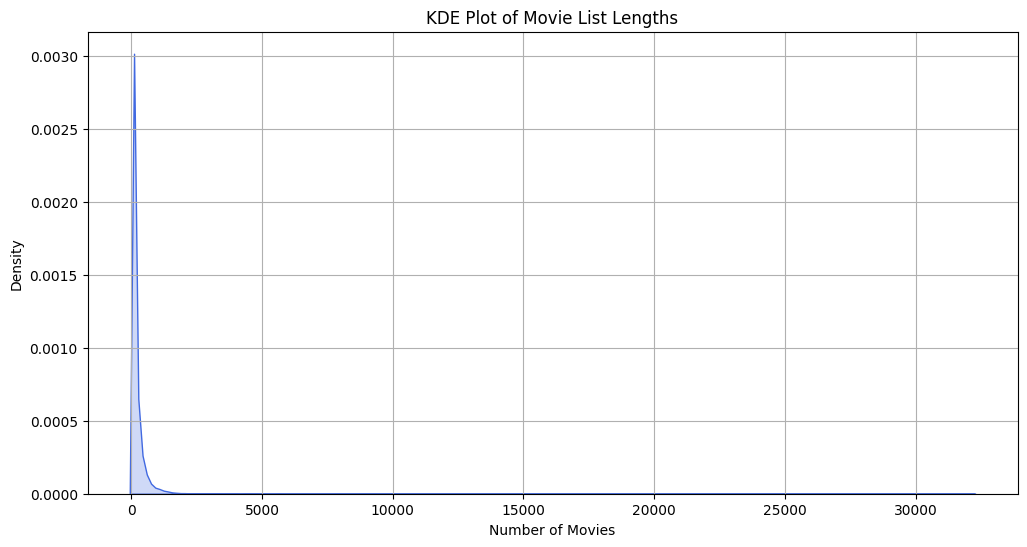

In [21]:
import seaborn as sns

# Plot KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(user_movie_sequences['len-of-list'], fill=True, color='royalblue')
plt.title('KDE Plot of Movie List Lengths')
plt.xlabel('Number of Movies')
plt.ylabel('Density')
plt.grid()
plt.show()

In [22]:
Q1 = user_movie_sequences['len-of-list'].quantile(0.25)
Q3 = user_movie_sequences['len-of-list'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = user_movie_sequences[(user_movie_sequences['len-of-list'] < lower_bound) | 
                                 (user_movie_sequences['len-of-list'] > upper_bound)]

print("Outliers:")
print(outliers)

Outliers:
        userId                                         movie-list  len-of-list
2            3  [{'timestamp': '2015-08-13', 'movie': 'Forrest...          656
11          12  [{'timestamp': '1999-10-24', 'movie': "Schindl...          736
12          13  [{'timestamp': '2009-03-25', 'movie': 'Miracle...          412
18          19  [{'timestamp': '2015-10-19', 'movie': 'Godfath...          458
22          23  [{'timestamp': '1999-11-18', 'movie': 'Being J...          371
...        ...                                                ...          ...
162518  162519  [{'timestamp': '2001-09-20', 'movie': 'Lord of...          522
162520  162521  [{'timestamp': '2008-04-12', 'movie': 'Star Tr...          389
162528  162529  [{'timestamp': '1998-02-22', 'movie': 'Titanic...          382
162532  162533  [{'timestamp': '2010-08-03', 'movie': 'Dr. Dol...          367
162533  162534  [{'timestamp': '2018-05-18', 'movie': 'Fight C...          487

[16365 rows x 3 columns]


In [25]:
import plotly.express as px

# Create a box plot using Plotly
fig = px.box(user_movie_sequences, 
              x='len-of-list', 
              title='Box Plot of Movie List Lengths', 
              labels={'len-of-list': 'Number of Movies'})

# Show the plot
fig.show()


ModuleNotFoundError: No module named 'plotly'